HW 5 Aiden Dillon

In [41]:
import numpy as np
from skimage import io, filters
from scipy.ndimage import convolve
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from scipy.special import j1



In [89]:
def showim(im_array, figsize=(4, 4), show_hist=False, nbins=None, bin_width=None, cmap='gray', vmin=None, vmax=None, titles=None):
    
    if isinstance(im_array, (list, tuple)):
        n_images = len(im_array)
        fig_width, fig_height = figsize
        plt.figure(figsize=(fig_width * n_images, fig_height))
        
        for idx, img in enumerate(im_array):
            plt.subplot(1, n_images, idx + 1)
            plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, (list, tuple)) and len(titles) == n_images:
                plt.title(titles[idx])
            elif titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
        plt.tight_layout()
        
        plt.show()
    else:
        plt.figure(figsize=figsize)
        
        if show_hist:
            plt.subplot(1, 2, 1)
            plt.imshow(im_array, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
            plt.subplot(1, 2, 2)
            
            im_flattened = im_array.ravel()
            min_val = np.floor(im_flattened.min())
            max_val = np.ceil(im_flattened.max())
            
            if bin_width is not None:
                bins = np.arange(min_val, max_val + bin_width, bin_width)
            elif nbins is not None:
                bins = nbins
            else:
                bins = int(max_val - min_val)
            
            plt.hist(im_flattened, bins=bins, color='black')
            plt.xlabel('Intensity Value')
            plt.ylabel('Frequency')
            plt.title('Image Intensity Histogram')
        
        else:
            plt.imshow(im_array, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
        plt.tight_layout()
        plt.show()


def calculate_rms_error(calculated_positions, true_positions):
    """
    Calculate the RMS error between calculated and true centroid positions.

    Parameters:
    calculated_positions (list of tuples or numpy array): List or array of (x_c, y_c) positions calculated from images.
    true_positions (list of tuples or numpy array): List or array of (x_0, y_0) true positions.

    Returns:
    float: The RMS error in pixels.
    """
    # Convert lists to numpy arrays for easier manipulation
    calculated_positions = np.array(calculated_positions)
    true_positions = np.array(true_positions)
    
    # Ensure arrays are 2D, even if only one position is provided
    if calculated_positions.ndim == 1:
        calculated_positions = calculated_positions.reshape(1, -1)
    if true_positions.ndim == 1:
        true_positions = true_positions.reshape(1, -1)
    
    # Calculate squared differences
    squared_diffs = (calculated_positions - true_positions) ** 2
    
    # Sum the squared differences in x and y, then take the mean and square root
    rms_error = np.sqrt(np.mean(np.sum(squared_diffs, axis=1)))
    
    return rms_error


def calculate_centroid(intensities, origin_center=False):
    """
    Calculate the centroid (center of mass) for 1D or 2D intensity arrays,
    with an option to shift the origin to the center of the array.

    Parameters:
    intensities (np.array): Array of intensity values, either 1D or 2D.
    origin_center (bool): If True, shifts the origin to the center of the array.
                          If False, uses the bottom-left corner as the origin.

    Returns:
    tuple: The centroid position. For 1D, returns (x_centroid,).
           For 2D, returns (x_centroid, y_centroid).
    """
    if intensities.ndim == 1:
        # 1D case
        n = len(intensities)
        positions = np.arange(n)
        if origin_center:
            center = (n - 1) / 2
            positions = positions - center  
        x_centroid = np.sum(positions * intensities) / np.sum(intensities)
        return x_centroid
    
    elif intensities.ndim == 2:
        # 2D case
        m, n = intensities.shape
        x_positions = np.arange(n)
        y_positions = np.arange(m)
        
        if origin_center:
            x_center = (n - 1) / 2
            y_center = (m - 1) / 2
            x_positions = x_positions - x_center 
            y_positions = y_positions - y_center  
        
        x_weights = np.sum(intensities, axis=0)  
        y_weights = np.sum(intensities, axis=1)  
        
        x_centroid = np.sum(x_positions * x_weights) / np.sum(intensities)
        y_centroid = np.sum(y_positions * y_weights) / np.sum(intensities)
        
        return (x_centroid, y_centroid)

    else:
        raise ValueError("Only 1D and 2D arrays are supported")


def sim_ps(N_camera, wavelength, NA, camera_scale, fine_scale, N_photon, offset = None, B = None):
    block_size = int(camera_scale / fine_scale)
    fine_grid_N = N_camera * block_size
    
    x = np.linspace(-fine_grid_N//2, fine_grid_N//2, fine_grid_N) * fine_scale
    y = np.linspace(-fine_grid_N//2, fine_grid_N//2, fine_grid_N) * fine_scale
    X, Y = np.meshgrid(x, y)
    if offset:
        xc, yc = offset
    else: xc, yc = 0, 0

    r = np.sqrt((X - xc)**2 + (Y - yc)**2)
    
    v = (2 * np.pi / wavelength) * NA * r
    
    psf_fine = np.zeros_like(v)
    psf_fine[v == 0] = 1
    psf_fine[v != 0] = 4 * (j1(v[v != 0]) / v[v != 0])**2
    
    psf_fine = psf_fine / psf_fine.sum()
    
    psf_camera = np.zeros((N_camera, N_camera))

    for i in range(N_camera):
        for j in range(N_camera):
            block = psf_fine[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            psf_camera[i, j] = np.sum(block)
    
    psf_camera /= np.sum(psf_camera)
    
    psf_camera *= N_photon
    
    noisy_psf = np.random.poisson(psf_camera)

    background = np.random.poisson(B, (N_camera, N_camera))

    final_image = noisy_psf + background

    
    return final_image




**Problem 2**: *Centroid Warmup*

**(i)** 

Consider  intensities  I_i = 0.2 i^0.5,  where  the  position  index  i  goes  from  0 to  999.  (In 
other words, the intensity increases as the square root of position). Where is the centroid?

In [70]:
positions = np.arange(1000)

intensities = 0.2 * np.sqrt(positions)
centroid = calculate_centroid(intensities)
print(f"Centroid position: {centroid:.2f}")


Centroid position: 599.71


**(ii)**

In [71]:
w = np.random.poisson(10, size=1000)
intensities = 30 / (positions + 20) + 0.05 * w
centroid = calculate_centroid(intensities)
print(f"Centroid position: {centroid:.2f}")

Centroid position: 448.33


**Problem 3**: *Centroid Localization*

The below section is just running code to check my simuluated images

In [54]:
def checkImage(simImage): 

    N = simImage.shape[0] # won't check that array is square 
    center_px = int((N-1)/2) 
    ratio_center_right1px = simImage[center_px,center_px] / simImage[center_px,center_px+1]
    print(f'Ratio #1: {ratio_center_right1px:.2f}') 
    if np.abs(ratio_center_right1px-1.06)<0.18: 
        print('Test 1: good') 
    else: 
        print('Test 1: failed!') 
    ratio_center_left1px = simImage[center_px,center_px] / simImage[center_px,center_px-1] 
    print(f'Ratio #2: {ratio_center_left1px:.2f}') 
    if np.abs(ratio_center_left1px-1.81)<0.4: 
        print('Test 2: good') 
    else: 
        print('Test 2: failed!') 
    ratio_center_up1px = simImage[center_px,center_px] / simImage[center_px-1,center_px] 
    print(f'Ratio #3: {ratio_center_up1px:.2f}') 
    if np.abs(ratio_center_up1px-1.36)<0.26: 
        print('Test 3: good') 
    else: 
        print('Test 3: failed!')

N_camera = 7
wavelength = 0.50
NA = 0.9
camera_scale = 0.1
fine_scale = 0.01
N_photons = 2000
offset = (0.04, 0)
bg = 2

test = sim_ps(N_camera=N_camera, wavelength=wavelength, NA=NA, camera_scale=camera_scale, 
              fine_scale=fine_scale, N_photon=N_photons, offset=offset, B=bg)

checkImage(test)

Ratio #1: 0.99
Test 1: good
Ratio #2: 1.53
Test 2: good
Ratio #3: 1.29
Test 3: good


**(a)**

*Calculating RMS of centroid for many simulated point source images*

Centroid root mean squared error for 1000 images: 0.037487


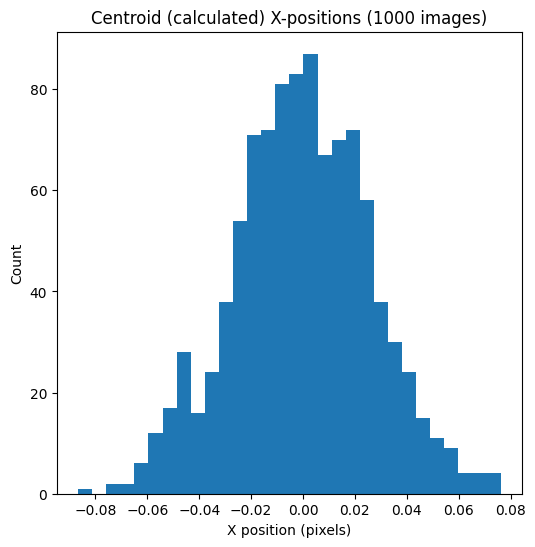

In [133]:
N_camera = 7
wavelength = 0.510
NA = 0.9
camera_scale = 0.1
fine_scale = 0.001
N_photons = 2000
center = (0.0, 0.0)
bg = 10

#image = sim_ps(N_camera=N_camera, wavelength=wavelength, NA=NA, camera_scale=camera_scale, 
              #fine_scale=fine_scale, N_photon=N_photons, offset=offset, B=bg)

#centroid = calculate_centroid(image, origin_center=True)
#rms = calculate_rms_error(center, centroid)

centers = []
centroids = []
x_list = []

m = 1000

for _ in range(m):

    image = image = sim_ps(N_camera=N_camera, wavelength=wavelength, NA=NA, camera_scale=camera_scale, 
              fine_scale=fine_scale, N_photon=N_photons, offset=offset, B=bg)
    
    centroid = calculate_centroid(image, origin_center=True)
    center = center

    centroids.append(centroid)
    centers.append(center)
    x_list.append(centroid[0])

rms = calculate_rms_error(centers, centroids)
print(f"Centroid root mean squared error for {m} images: {rms:5f}")

plt.figure(figsize=(6,6))
plt.hist(x_list, bins=30)
plt.title(f"Centroid (calculated) X-positions ({m} images)")
plt.xlabel('X position (pixels)')
plt.ylabel('Count');


**(b)**

*RMS Error as N_Photons changes*

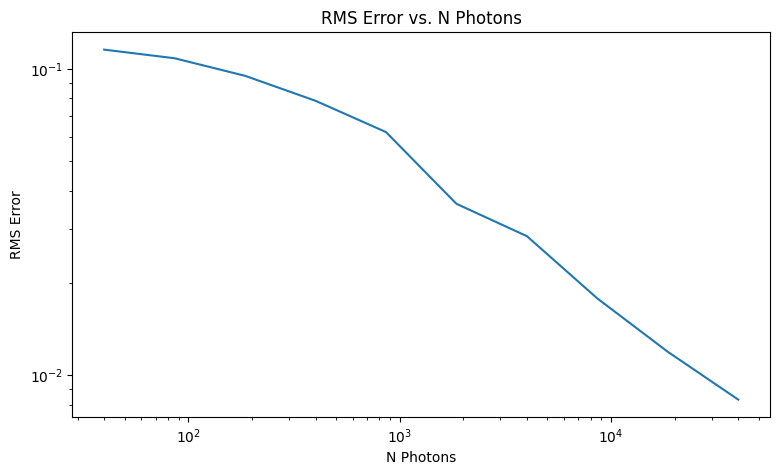

In [142]:
N_camera = 7
wavelength = 0.510
NA = 0.9
camera_scale = 0.1
fine_scale = 0.001
center = (0.0, 0.0)
bg = 10

m = 100
rms_list = []
N_photons_list = np.logspace(np.log10(40), np.log10(40000), num=10)

for N_photons in N_photons_list:
    
    centers = []
    centroids = []
    
    N_photons = N_photons

    for _ in range(m):

        image = image = sim_ps(N_camera=N_camera, wavelength=wavelength, NA=NA, camera_scale=camera_scale, 
                fine_scale=fine_scale, N_photon=N_photons, offset=offset, B=bg)
        
        centroid = calculate_centroid(image, origin_center=True)
        center = center

        centroids.append(centroid)
        centers.append(center)

    rms = calculate_rms_error(centers, centroids)
    rms_list.append(rms)

plt.figure(figsize=(9,5))
plt.loglog(N_photons_list,rms_list)
plt.xlabel('N Photons')
plt.ylabel('RMS Error')
plt.title('RMS Error vs. N Photons');

Does  it  have  the  shape  you expected? See the “Additional Notes” document for comment

**(c)** 

*X-error as simulated point source center changes*

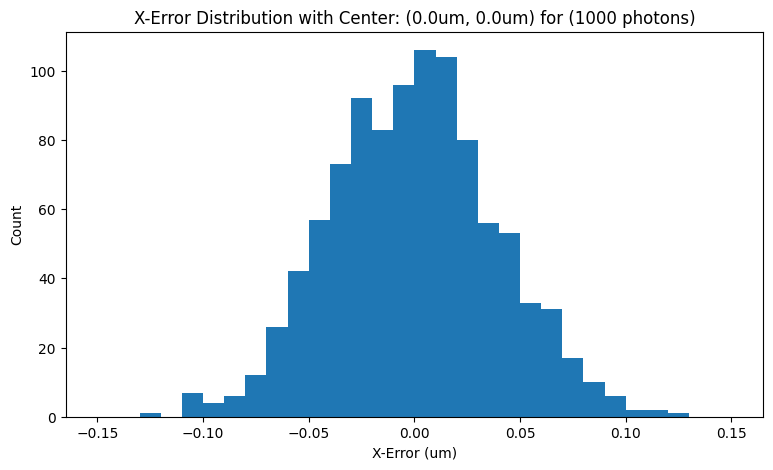

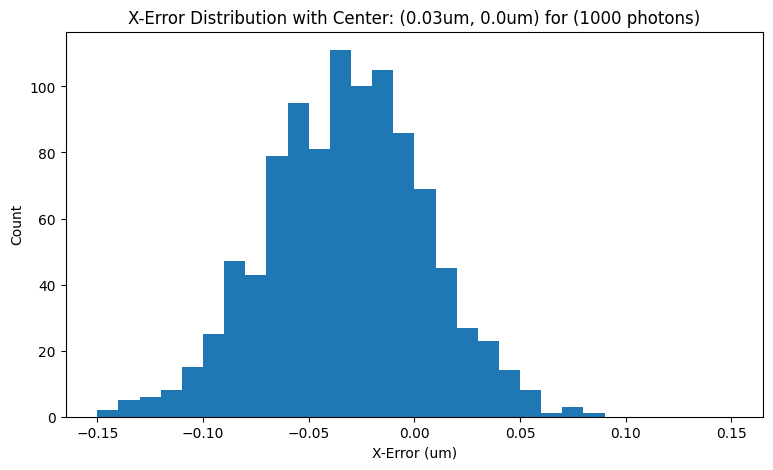

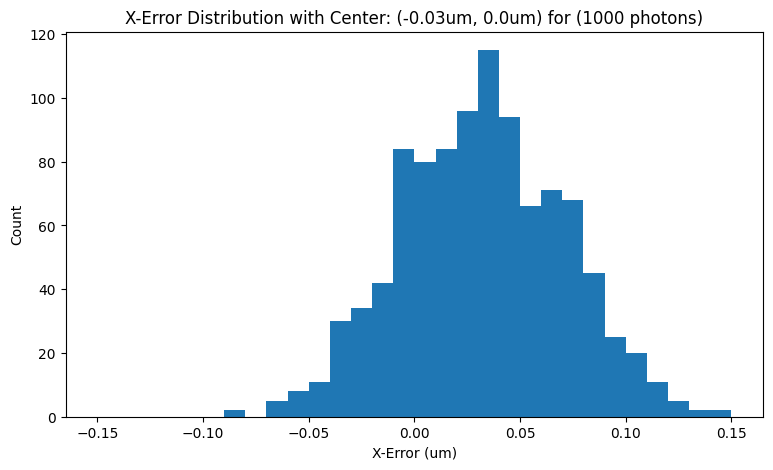

In [155]:
N_camera = 7
wavelength = 0.510
NA = 0.9
N_photons = 1000
camera_scale = 0.1
fine_scale = 0.001
bg = 10

m = 1000
center_list = [(0.0, 0.0), (0.03, 0.0), (-0.03, 0.0)]

for center in center_list:

    x_error_list = []

    for _ in range(m):

        image = image = sim_ps(N_camera=N_camera, wavelength=wavelength, NA=NA, camera_scale=camera_scale, 
                fine_scale=fine_scale, N_photon=N_photons, offset=offset, B=bg)
        
        centroid = calculate_centroid(image, origin_center=True)
        x_centroid = centroid[0]
        x_error = x_centroid - center[0]

        x_error_list.append(x_error)

    plt.figure(figsize=(9,5))
    plt.hist(x_error_list, bins=30, range = (-0.15, 0.15))
    plt.xlabel('X-Error (um)')
    plt.ylabel('Count')
    plt.title(f"X-Error Distribution with Center: ({center[0]}um, {center[1]}um) for ({N_photons} photons)");

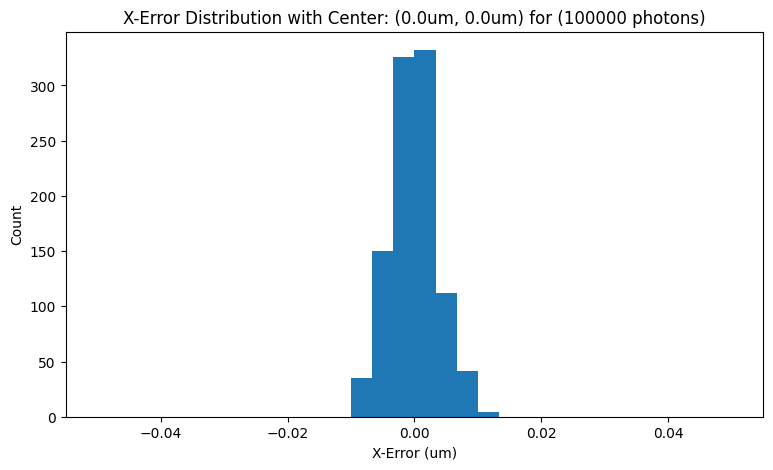

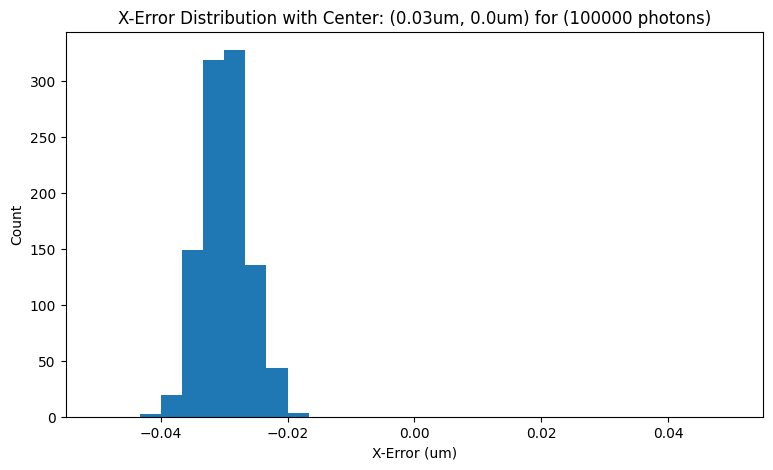

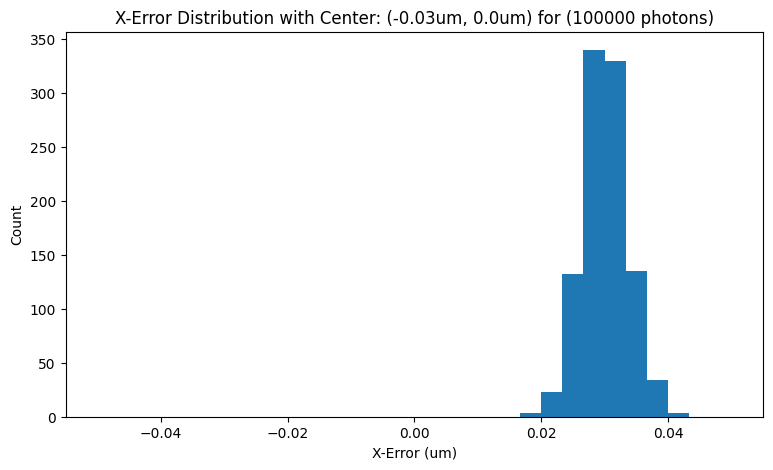

In [157]:
N_camera = 7
wavelength = 0.510
NA = 0.9
N_photons = 100000
camera_scale = 0.1
fine_scale = 0.001
bg = 10

m = 1000
center_list = [(0.0, 0.0), (0.03, 0.0), (-0.03, 0.0)]

for center in center_list:

    x_error_list = []

    for _ in range(m):

        image = image = sim_ps(N_camera=N_camera, wavelength=wavelength, NA=NA, camera_scale=camera_scale, 
                fine_scale=fine_scale, N_photon=N_photons, offset=offset, B=bg)
        
        centroid = calculate_centroid(image, origin_center=True)
        x_centroid = centroid[0]
        x_error = x_centroid - center[0]

        x_error_list.append(x_error)

    plt.figure(figsize=(9,5))
    plt.hist(x_error_list, bins=30, range = (-0.05, 0.05))
    plt.xlabel('X-Error (um)')
    plt.ylabel('Count')
    plt.title(f"X-Error Distribution with Center: ({center[0]}um, {center[1]}um) for ({N_photons} photons)");